# HDF5 
  계층적 데이터 형식, 용량이 매우 큰 데이터에 효과적으로 접근하기 위해 만들어진 데이터 프레임웍으로 공학용으로 널리 사용됨


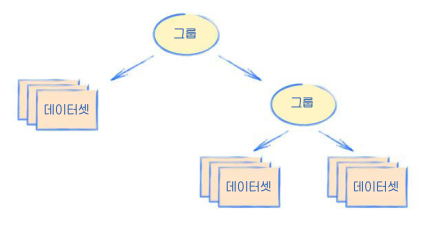

In [24]:
# 아래 경로에 zip파일을 google drive에 저장하고 사용
# https://drive.google.com/file/d/11vSNWOyftsgyHKv-qf7c-S4VnJWeUe5T/view?usp=share_link
# 구글드라이브 경로 : /content/drive/MyDrive/celeba.zip

In [23]:
import h5py
import zipfile
import imageio
import os
# 현재 경로에 h5py 생성하기
with h5py.File('./celeba_aligned_small.h5py', 'w') as hf:

    count = 1
# 이미지 데이터 불러와서 hdf5 구조로 변경

    with zipfile.ZipFile('/content/drive/MyDrive/celeba.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          #img_list.append(img)
          os.remove(ofile)
          count = count + 1
          if (count%10000 == 0):
            print(count, img.shape)
            pass
          hf.create_dataset(i, data=img, compression="gzip", compression_opts=9)
          if (count == 20000):
            break

AttributeError: ignored

# HDF5 데이터 탐색

In [2]:
import h5py

import numpy as np
import matplotlib.pyplot as plt

# HDF5 파일 열어서 내부 그룹 확인

In [3]:
with h5py.File('./celeba_aligned_small.h5py', 'r') as file_object:  
  for group in file_object:
    print(group)

img_align_celeba_20000


<HDF5 dataset "000001.jpg": shape (218, 178, 3), type "|u1">


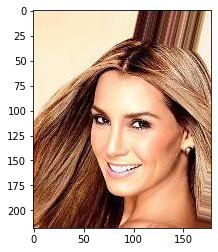

In [4]:
with h5py.File('./celeba_aligned_small.h5py', 'r') as file_object:
  dataset = file_object['img_align_celeba_20000']  
  file_list = np.array(dataset)
  image = np.array( dataset[file_list[0]] )
  plt.imshow(image, interpolation='none')
  print(dataset[file_list[0]])

In [5]:
image.shape

(218, 178, 3)

# cuda 확인 및 설정

In [6]:
import torch
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

# 데이터셋 클래스

In [7]:
from torch.utils.data import Dataset
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba_20000']
        self.filelist = np.array(self.dataset)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()        
        img = np.array( self.dataset[file_list[index]] )        
        return torch.cuda.FloatTensor(img) / 255.0
    
    def plot_image(self, index):
      img = np.array( self.dataset[file_list[index]] )   
      plt.imshow(img, interpolation='nearest')        
    
    

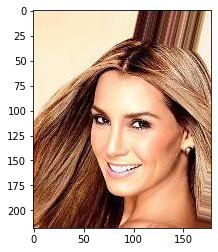

In [8]:
celeba_dataset =  CelebADataset('./celeba_aligned_small.h5py')
celeba_dataset.plot_image(0)

임의의 데이터 생성

In [10]:
import torch.nn as nn
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)    

# 판별기

In [11]:
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

class Discriminator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
       # 신경망 레이어 정의
        self.model = nn.Sequential(
            View(218*178*3),
            
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # 손실 함수 생성
        self.loss_function = nn.BCELoss()

        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []       
    
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 신경망 출력 계산
        outputs = self.forward(inputs)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))        

판별기가 임의의 노이즈와 실제 데이터를 구별할 수 있는지 테스트

In [13]:
D = Discriminator()
# 모델을 cuda로 배치
D.to(device)

for image_data_tensor in celeba_dataset:
    # 실제 데이터
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # 생성된 데이터
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))    

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000


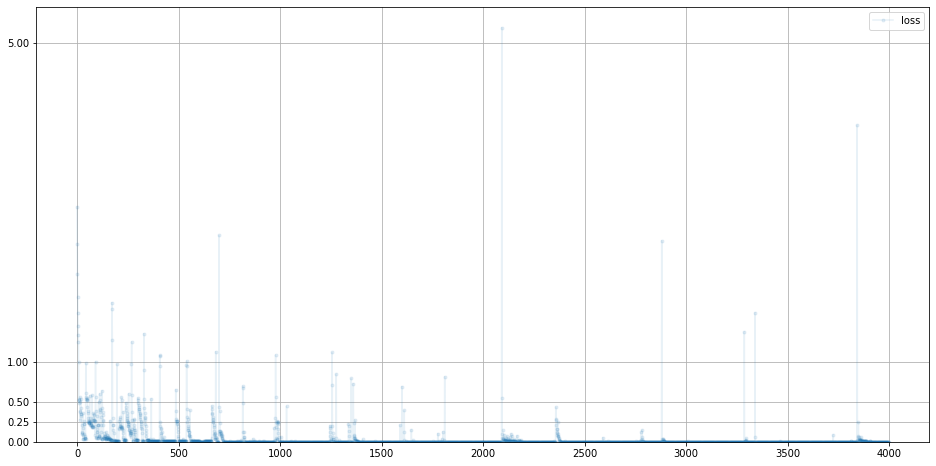

In [14]:
D.plot_progress()

In [17]:
# 진짜와 가짜 구분
import random
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )  

for i in range(4):
  print( D.forward( generate_random_image((218,178,3))).item() )
    

0.999707043170929
0.9999188184738159
0.9999673366546631
0.9998718500137329
4.481010910240002e-05
5.684537609340623e-05
4.5635471906280145e-05
4.4908974814461544e-05


# 생성기 모델

In [18]:
class Generator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []       
        
    
    
    def forward(self, inputs):        
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # 신경망 출력 계산
        g_output = self.forward(inputs)
        
        # 판별기에 값 전달
        d_output = D.forward(g_output)
        
        # 오차 계산
        loss = D.loss_function(d_output, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()       
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        

GAN 훈련

In [19]:
D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # 판별기와 생성기 훈련

  for image_data_tensor in celeba_dataset:
    # 참일 경우 판별기 훈련
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
    # 거짓일 경우 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
    # 생성기 훈련
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))


epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000


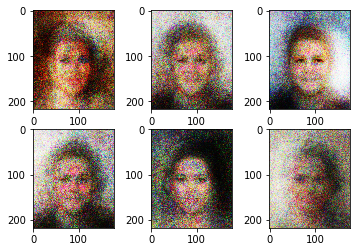

In [21]:

for i in range(6):
  plt.subplot(2,3, i+1)
  output = G.forward(generate_random_seed(100))
  img = output.detach().cpu().numpy()
  plt.imshow(img, interpolation='none', cmap='Blues')